## Pair GGL with near-identical deflectors to make PDSPLs

Here we prepare 3 different sets of PDSPL samples by pairing GGL systems with near-identical deflectors from the SLSim LSST GGL catalog. We then analyze the paired systems.

In [43]:
# Standard imports
import corner
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde
import pickle
from tqdm import tqdm

# Astropy imports
from astropy.table import Table
from astropy import units as u

# Lenstronomy, HierArc imports
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from pdspl_analysis_utils import kdtree_matching_n_dim, get_pairs_table_PDSPL, normalize_data
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

plt.style.use("../paper_style.mplstyle")

# warnings filter
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
FIGURES_DIR = "../figures/"

## Prepare LSST like samples for Y1, Y10, and 4MOST 

In [72]:
########################################################
### Load the GGL data tables
########################################################

sky_area = u.Quantity(20000, u.deg**2)

GGL_table_LSST_Y10 = Table.read(f"../data/GGL_Catalogs/GGL_20000.0_SQDEG_LSSTY10_SNR_20_seeing_0.5_contrast_02.fits", format='fits')
GGL_table_4MOST = Table.read(f"../data/GGL_Catalogs/GGL_20000.0_SQDEG_4MOST_SNR_20_seeing_0.2_contrast_no.fits", format='fits')


for GGL_data_table in [GGL_table_LSST_Y10, GGL_table_4MOST]:
    # add g-r and r-i colors for deflector
    GGL_data_table['color_D_gr'] = GGL_data_table['mag_D_g'] - GGL_data_table['mag_D_r']
    GGL_data_table['color_D_ri'] = GGL_data_table['mag_D_r'] - GGL_data_table['mag_D_i']

    # add log columns
    GGL_data_table['log_R_e_kpc'] = np.log10(GGL_data_table['R_e_kpc'])
    GGL_data_table['log_Sigma_half_Msun/pc2'] = np.log10(GGL_data_table['Sigma_half_Msun/pc2'])
    GGL_data_table['log_sigma_v_D'] = np.log10(GGL_data_table['sigma_v_D'])

    # rename size_D to R_e_arcsec for clarity
    GGL_data_table.rename_column('size_D', 'R_e_arcsec')

# LSST Y1 - sort LSST Y10 by SNR and take the top N_Y1 = N_Y10 / sqrt(10) lenses
GGL_table_LSST_Y1 = GGL_table_LSST_Y10.copy()
GGL_table_LSST_Y1.sort('snr_i', reverse=True)
GGL_table_LSST_Y1 = GGL_table_LSST_Y1[:int(len(GGL_table_LSST_Y10) / np.sqrt(10))]

# 4MOST spec-z will be brightest 10000 lenses
GGL_table_4MOST_specz = GGL_table_4MOST.copy()
GGL_table_4MOST_specz.sort('mag_D_r')
GGL_table_4MOST_specz = GGL_table_4MOST_specz[:10000]

# 4MOST spec-z + sigma_v will be brightest 5000 lenses
GGL_table_4MOST_specz_sigma = GGL_table_4MOST.copy()
GGL_table_4MOST_specz_sigma.sort('mag_D_r')
GGL_table_4MOST_specz_sigma = GGL_table_4MOST_specz_sigma[:5000]


# print number of lenses in each catalog
print(f"Number of lenses in LSST Y10 catalog: {len(GGL_table_LSST_Y10)}")
print(f"Number of lenses in LSST Y1 catalog: {len(GGL_table_LSST_Y1)}")
print(f"Number of lenses in 4MOST catalog: {len(GGL_table_4MOST)}")
print(f"Number of lenses in 4MOST spec-z catalog: {len(GGL_table_4MOST_specz)}")
print(f"Number of lenses in 4MOST spec-z + sigma_v catalog: {len(GGL_table_4MOST_specz_sigma)}")

Number of lenses in LSST Y10 catalog: 116471
Number of lenses in LSST Y1 catalog: 36831
Number of lenses in 4MOST catalog: 16046
Number of lenses in 4MOST spec-z catalog: 10000
Number of lenses in 4MOST spec-z + sigma_v catalog: 5000


In [13]:
########################################################
### Apply LSST magnitude depth cuts and produce pdspl_samples
########################################################

# Define all LSST sample configurations in one structured dictionary
pdspl_samples = {
    "lsst_y1": {
        "table": GGL_table_LSST_Y1,
        "title": f"LSST Y1 ({sky_area} deg$^2$)",
        "label": "LSST Y1",
        "name": "LSST Y1",
        "color": "tab:orange",
        "desc": "Single exposure; extended-source $i < 22.5$",
        "selc_func_latex": "$m_{i} < 22.5$"
    },

    "lsst_y10": {
        "table": GGL_table_LSST_Y10,
        "title": f"LSST 10-year Coadd Depth ({sky_area} deg$^2$)",
        "label": "LSST Y10 ($i < 24.3$)",
        "name": "LSST Y10",
        "color": "green",
        "desc": "10-year coadd; extended-source $i < 24.3$",
        "selc_func_latex": "$m_{i} < 24.3$"
    },

    "lsst_4most_spec-z": {
        "table": GGL_table_4MOST_specz,
        "title": f"LSST + 4MOST spec-z Sample ({sky_area} deg$^2$)",
        "label": "4MOST ($r < 24, z_S < 1.5$)",
        "name": "4MOST ($z^{\\rm spec}$)",
        "color": "red",
        "desc": "Spectroscopic 4MOST limit; $r < 24, z_S < 1.5$",
        "selc_func_latex": "$m_{r} < 24.0, z_S < 1.5$"
    },

    "lsst_4most_spec-z_sigma_v": {
        "table": GGL_table_4MOST_specz_sigma,
        "title": f"LSST + 4MOST spec-z + "+"$\\sigma_{v, D}$"+f" Sample ({sky_area} deg$^2$)",
        "label": "4MOST ($r < 24, z_S < 1.5$)",
        "name": "4MOST ($z^{\\rm spec}$ + $\\sigma_{v, D}$)",
        "color": "purple",
        "desc": "Spectroscopic 4MOST limit; $r < 24, z_S < 1.5$",
        "selc_func_latex": "$m_{r} < 24.0, z_S < 1.5$"
    },
}

# Build filtered tables
for key, s in pdspl_samples.items():
    s["count"] = len(s["table"])

# Summary
print('-'*80)
print(f"Sky area: {sky_area} deg^2")
print('-'*80)

for key, s in pdspl_samples.items():
    print(f"{s['name']:<62}# lenses: {s['count']:<6}, # unique deflectors: {len(np.unique(s['table']['z_D']))}")

print('-'*80)

--------------------------------------------------------------------------------
Sky area: 20000.0 deg2 deg^2
--------------------------------------------------------------------------------
LSST Y1                                                       # lenses: 38823 , # unique deflectors: 38653
LSST Y10                                                      # lenses: 116471, # unique deflectors: 114314
4MOST ($z^{\rm spec}$)                                        # lenses: 10000 , # unique deflectors: 9646
4MOST ($z^{\rm spec}$ + $\sigma_{v, D}$)                      # lenses: 5000  , # unique deflectors: 4761
--------------------------------------------------------------------------------


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the follow

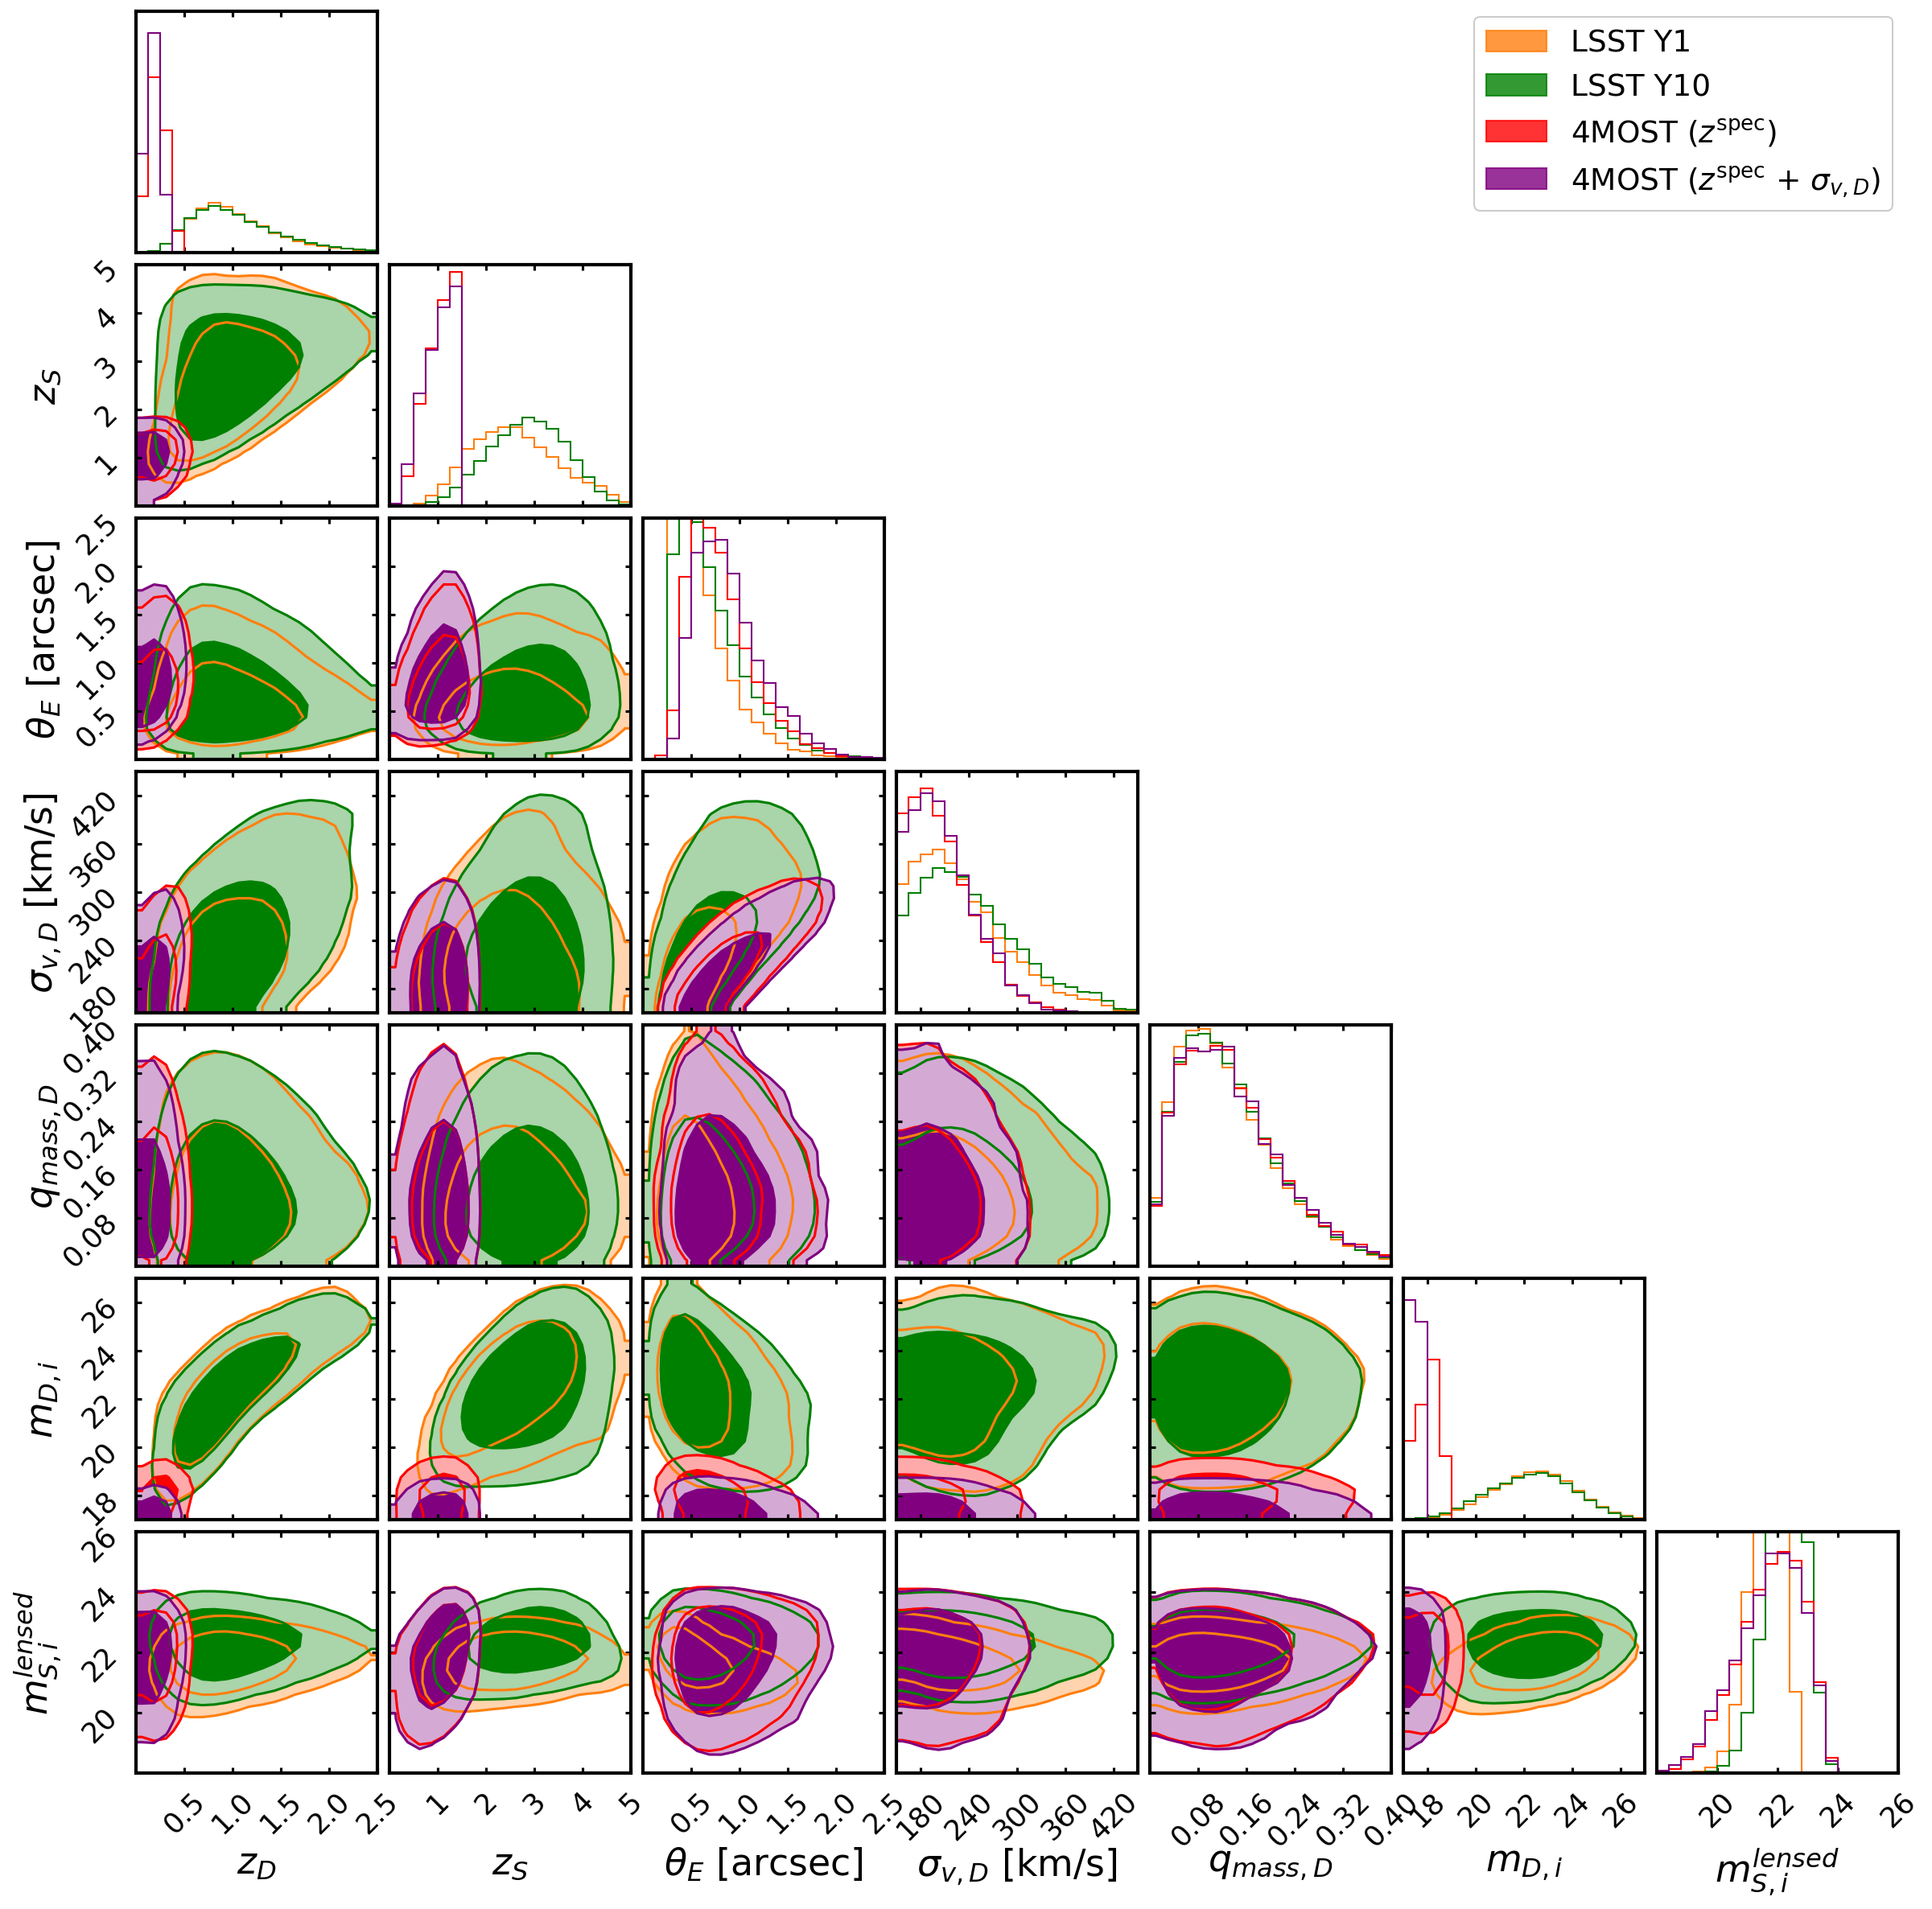

In [58]:
###################################################################
### Make corner plot of the data sets
###################################################################

samples_to_plot = ['lsst_y1', 'lsst_y10', 'lsst_4most_spec-z', 'lsst_4most_spec-z_sigma_v']

key_list = ['z_D',
            'z_S',
            'theta_E',
            'sigma_v_D',
            'e_mass_D',
            'mag_D_i', 
            'mag_S_i_lensed']
key_latex_labels = {
    'z_D': r'$z_D$',
    'z_S': r'$z_S$',
    'theta_E': r'$\theta_E$ [arcsec]',
    'sigma_v_D': r'$\sigma_{v, D}$ [km/s]',
    'e_mass_D': r'$q_{mass, D}$',
    'mag_D_i': r'$m_{D, i}$',
    'mag_S_i_lensed': r'$m_{S, i}^{lensed}$',
}

# --- Define plot ranges based on the reference image ---
plot_ranges = [
    (0.0, 2.5),  # z_D
    (0.0, 5.0),  # z_S
    (0.0, 2.5),  # theta_E
    (150, 450),  # sigma_v_D
    (0, 0.4),  # e_mass_D
    (17, 27),    # mag_D_i
    (18, 26)     # mag_S_i_lensed
]


fig_corner_ref = None

for sample_key in samples_to_plot:
    data_corner_sample = [pdspl_samples[sample_key]['table'][key] for key in key_list]
    data_corner_sample = np.array(data_corner_sample).T

    if fig_corner_ref is None:
        fig_corner_ref = corner.corner(
            data_corner_sample,
            labels=[key_latex_labels[key] for key in key_list],
            range=plot_ranges, 
            hist_kwargs={"density": True},
            color=pdspl_samples[sample_key]['color'],
            smooth=1,
            plot_datapoints=False,
            fill_contours=True,
            levels=(0.68, 0.95)
        );
    else:
        corner.corner(
            data_corner_sample,
            labels=[key_latex_labels[key] for key in key_list],
            range=plot_ranges, 
            hist_kwargs={"density": True},
            color=pdspl_samples[sample_key]['color'],
            smooth=1,
            fig=fig_corner_ref,
            plot_datapoints=False,
            fill_contours=True,
            levels=(0.68, 0.95)
        );


# fig_corner_ref.legend(
#     ['SLSim 20000 deg$^2$'] +
#     [pdspl_samples[sample_key]['name'] for sample_key in samples_to_plot],
#     loc='upper right',
#     fontsize=20  # Increased legend font size
# )
legend_handles = []

# 1. Add Reference Handle (Grey Patch)
# legend_handles.append(mpatches.Patch(color='black', alpha=0.3, label='SLSim 20K deg$^2$'))
# legend_handles.append(mlines.Line2D([], [], color='black', label='_nolegend_')) # Outline trick

# 2. Add Sample Handles
for sample_key in samples_to_plot:
    color = pdspl_samples[sample_key]['color']
    name = pdspl_samples[sample_key]['name']
    
    # We combine a transparent patch (fill) and a solid line (outline) for the legend
    patch = mpatches.Patch(color=color, alpha=0.8, label=name)
    legend_handles.append(patch)

# Add the legend to the figure (placing it in the upper right empty space)
fig_corner_ref.legend(
    handles=legend_handles,
    loc='upper right',
    bbox_to_anchor=(0.98, 0.98), # Adjust these coordinates to move the box
    fontsize=18,
    frameon=True, 
    facecolor='white',
    framealpha=1.0
)

# make the font size of the labels and titles larger
for ax in fig_corner_ref.get_axes():
    # Increase tick label size and add padding
    ax.tick_params(axis='both', which='major', labelsize=17, pad=8)
    
    # Increase axis label size
    ax.xaxis.label.set_size(22)
    ax.yaxis.label.set_size(22)
    
    # Increase title size (for 1D histograms)
    ax.title.set_size(22)

# fig_corner.savefig(f"../figures/slsim_corner_GGL_all_samples.png", bbox_inches='tight', dpi=300)
fig_corner_ref.savefig(f"../figures/slsim_corner_GGL_all_samples_v2.pdf", bbox_inches='tight', dpi=300)

In [16]:
# --- Cosmology used in SLSim ---
cosmology = "w0waCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
om_true = 0.3
w0_true = -1
wa_true = 0
h0_true = 70
kwargs_cosmo_true = {"h0": h0_true, "om": om_true, "w0": w0_true, "wa": wa_true}  # cosmological model of the forecast

cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)

In [ ]:
########################################################
### Pairing Properties and Titles
########################################################

# --- Deflector properties used for pairing ---
keys_to_pair_deflectors = [
    'z_D',
    'R_e_arcsec',
    'mag_D_i',
    'color_D_gr',
    'color_D_ri',
]

keys_to_pair_deflectors_latex = {
    'z_D': r'$z_{\mathrm{lens}}$',
    'R_e_kpc': r'$R_e$ [kpc]',
    'R_e_arcsec': r'$R_e$ [arcsec]',
    'mag_D_i': r'$m_i$',
    'color_D_gr': r'$m_g - m_r$',
    'color_D_ri': r'$m_r - m_i$',
    'sigma_v_D': r'$\sigma_{v, D}$ [km/s]',
} 

# assign pairing keys for each sample
for key, s in pdspl_samples.items():
    if key == 'lsst_4most_spec-z_sigma_v':
        pairing_keys = ['z_D', 'R_e_arcsec', 'sigma_v_D']
    else:
        pairing_keys = keys_to_pair_deflectors

    s['pairing_keys'] = pairing_keys
    s['pairing_title'] = "Paired w/ kD-Tree in " + ", ".join(
        [keys_to_pair_deflectors_latex[k] for k in pairing_keys]
    )
    s['pairing_keys_latex'] = ', '.join(
        [keys_to_pair_deflectors_latex[k] for k in pairing_keys]
    )

########################################################
## define dissimilarity estimator parameters for each sample
##########################################################
# --- Define which parameters to include in the dissimilarity estimator ---
keys_to_use_for_dissimilarity = [
    "rel_diff_R_e_arcsec",
    "rel_diff_z_D",
    "rel_diff_mag_D_i",
    "rel_diff_color_D_gr",
    "rel_diff_color_D_ri"
]

# --- (optional) Define pretty LaTeX labels for each key ---
key_latex_map = {
    "rel_diff_R_e_arcsec": r"\frac{\Delta R_e}{R_e}",
    "rel_diff_z_D": r"\frac{\Delta z_D}{z_D}",
    "rel_diff_mag_D_i": r"\frac{\Delta m_i}{m_i}",
    "rel_diff_color_D_gr": r"\frac{\Delta c_{gr}}{c_{gr}}",
    "rel_diff_color_D_ri": r"\frac{\Delta c_{ri}}{c_{ri}}"
}

# assign dissimilarity keys for each sample
for key, s in pdspl_samples.items():
    if key == 'lsst_4most_spec-z_sigma_v':
        dissimilarity_keys = [
            "rel_diff_z_D",
            "rel_diff_R_e_arcsec",
            "rel_diff_sigma_v_D"
        ]
    else:
        dissimilarity_keys = keys_to_use_for_dissimilarity

    s['dissimilarity_keys'] = dissimilarity_keys
############################################################

In [ ]:
########################################################
##  Get pairs table for each LSST sample
##  Run 100 Realizations of error assigning on z_D, sigma_v_D and R_e_arcsec for robust statistics
########################################################

N_realizations = 100
print(f"Running {N_realizations} realizations for robust statistics...")

# Dictionary to store binned statistics for every run
# Structure: mc_results[sample_key] = {'binned_dissim': [[run1], [run2]...], 'binned_scatter': ...}
mc_results = {k: {'binned_dissim': [], 'binned_scatter': []} for k in pdspl_samples.keys()}

for i_realization in tqdm(range(N_realizations), desc="Realizations"):

    ########################################################
    ## Adding errors on z_D and sigma_v_D and R_e_arcsec
    ##########################################################

    for sample_key in pdspl_samples.keys():

        # z_D errors
        if sample_key in ['lsst_y1', 'lsst_y10']:    
            z_D_error = 0.03 * (1 + pdspl_samples[sample_key]['table']['z_D'])  # photometric redshift error
            sample_z_Ds_with_errors = pdspl_samples[sample_key]['table']['z_D'] + np.random.normal(loc=0, scale=z_D_error)
        elif sample_key in ['lsst_4most_spec-z', 'lsst_4most_spec-z_sigma_v']:
            z_D_error = 1e-4 # spectroscopic redshift error
            sample_z_Ds_with_errors = pdspl_samples[sample_key]['table']['z_D'] + np.random.normal(loc=0, scale=z_D_error)  
        else:
            z_D_error = 0
            sample_z_Ds_with_errors = pdspl_samples[sample_key]['table']['z_D']
        
        # sigma_v_D errors
        if sample_key == 'lsst_4most_spec-z_sigma_v':
            sigma_v_error = 10.0  # fixed 10 km/s error
            sample_sigma_v_Ds_with_errors = pdspl_samples[sample_key]['table']['sigma_v_D'] + np.random.normal(loc=0, scale=sigma_v_error)
        else:
            sigma_v_error = 0
            sample_sigma_v_Ds_with_errors = pdspl_samples[sample_key]['table']['sigma_v_D']

        # R_e errors => 5-10% error on R_e
        R_e_error = 0.05 * (pdspl_samples[sample_key]['table']['R_e_arcsec'])
        sample_R_e_arcsec_with_errors = pdspl_samples[sample_key]['table']['R_e_arcsec'] + np.random.normal(loc=0, scale=R_e_error)

        # add these errors to a new table (overwrites previous iteration)
        pdspl_samples[sample_key]['table_with_errors'] = pdspl_samples[sample_key]['table'].copy()
        pdspl_samples[sample_key]['table_with_errors']['z_D'] = sample_z_Ds_with_errors
        pdspl_samples[sample_key]['table_with_errors']['sigma_v_D'] = sample_sigma_v_Ds_with_errors
        pdspl_samples[sample_key]['table_with_errors']['R_e_arcsec'] = sample_R_e_arcsec_with_errors

        pdspl_samples[sample_key]['table_with_errors']['err_z_D'] = z_D_error
        pdspl_samples[sample_key]['table_with_errors']['err_sigma_v_D'] = sigma_v_error
        pdspl_samples[sample_key]['table_with_errors']['err_R_e_arcsec'] = R_e_error

    ########################################################
    ## define dissimilarity estimator parameters
    ##########################################################
    keys_to_use_for_dissimilarity = [
        "rel_diff_R_e_arcsec", "rel_diff_z_D", "rel_diff_mag_D_i",
        "rel_diff_color_D_gr", "rel_diff_color_D_ri"
    ]

    for key, s in pdspl_samples.items():
        if key == 'lsst_4most_spec-z_sigma_v':
            dissimilarity_keys = ["rel_diff_z_D", "rel_diff_R_e_arcsec", "rel_diff_sigma_v_D"]
        else:
            dissimilarity_keys = keys_to_use_for_dissimilarity
        s['dissimilarity_keys'] = dissimilarity_keys

    ########################################################
    ###  Get pairs table for each LSST sample
    ########################################################

    for sample_key, s in pdspl_samples.items():
        table = s["table"]
        if len(table) < 2: continue

        pairing_keys = s['pairing_keys']
        pairing_title = s['pairing_title']

        # Normalized feature space
        points = np.stack(
            [normalize_data(s['table_with_errors'][pk], type='zscore') for pk in pairing_keys],
            axis=1
        )

        # Pair with KD-tree
        indices, _ = kdtree_matching_n_dim(points=points, n_neighbors=2, unique_pairs=True)

        # Build pairs table
        pairs_table = get_pairs_table_PDSPL(table, pair_indices=indices, cosmo=cosmo_true, progress_bar=False)
        pairs_table_with_errors = get_pairs_table_PDSPL(s['table_with_errors'], pair_indices=indices, cosmo=cosmo_true, progress_bar=False)

        # Compute summary stats
        num_lenses = len(table)
        num_pairs = len(pairs_table)
        beta_ratio = pairs_table["beta_E_pseudo"] / pairs_table["beta_E_DSPL"]
        scatter_in_beta_E = np.std(1 - beta_ratio)
        mean_beta_ratio = np.mean(beta_ratio)
        median_beta_ratio = np.median(beta_ratio)

        s["pairs_analysis"] = {
            "pairs_table": pairs_table,
            "pairs_table_with_errors": pairs_table_with_errors,
            "num_lenses": num_lenses,
            "num_pairs": num_pairs,
            "scatter_in_beta_E": scatter_in_beta_E,
            "mean_beta_ratio": mean_beta_ratio,
            "median_beta_ratio": median_beta_ratio,
            "pairing_keys": pairing_keys,
            "pairing_title": pairing_title,
            "pairing_points": points,
        }

    ########################################################
    ###  Find dissimilarity estimator
    ########################################################
    for sample_key, s in pdspl_samples.items():
        pairs_table_with_errors = s["pairs_analysis"]["pairs_table_with_errors"]
        diffs = np.array([pairs_table_with_errors[k] for k in s['dissimilarity_keys']])
        dissimilarity_estimator = np.sqrt(np.mean(diffs**2, axis=0))
        s["pairs_analysis"]["pairs_table_with_errors"]['dissimilarity'] = dissimilarity_estimator

        # --- STORE DATA FOR MC ANALYSIS ---
        # We calculate the binned stats for THIS realization and store them
        tbl_err = s["pairs_analysis"]["pairs_table_with_errors"]
        tbl = s["pairs_analysis"]["pairs_table"]
        
        dissimilarities = tbl_err['dissimilarity']
        delta_beta_E = 1 - tbl['beta_E_pseudo'] / tbl['beta_E_DSPL']
        
        # Apply mask
        mask = (tbl_err['dissimilarity'] < 0.1) & (np.isfinite(delta_beta_E))
        dissimilarities = dissimilarities[mask]
        delta_beta_E = delta_beta_E[mask]
        
        # Binning for this realization
        percentiles = np.percentile(dissimilarities, np.arange(0, 101, 10))
        digitized = np.digitize(dissimilarities, percentiles)

        run_binned_dissim = []
        run_binned_scatter = []

        for i in range(1, len(percentiles)):
            bin_mask = digitized == i
            if np.sum(bin_mask) > 0:
                run_binned_dissim.append(np.median(dissimilarities[bin_mask]))
                run_binned_scatter.append(np.nanstd(delta_beta_E[bin_mask]))
            else:
                run_binned_dissim.append(np.nan)
                run_binned_scatter.append(np.nan)
        
        mc_results[sample_key]['binned_dissim'].append(run_binned_dissim)
        mc_results[sample_key]['binned_scatter'].append(run_binned_scatter)


print("MC Loop Complete.")

Running 100 realizations for robust statistics...


Realizations: 100%|██████████| 100/100 [59:54<00:00, 35.95s/it]

MC Loop Complete.


LSST Y1: Linear fit: slope = 0.808, intercept = 0.152


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the follow

LSST Y10: Linear fit: slope = 0.911, intercept = 0.149
4MOST ($z^{\rm spec}$): Linear fit: slope = 0.683, intercept = 0.066
4MOST ($z^{\rm spec}$ + $\sigma_{v, D}$): Linear fit: slope = 0.444, intercept = 0.044


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the follow

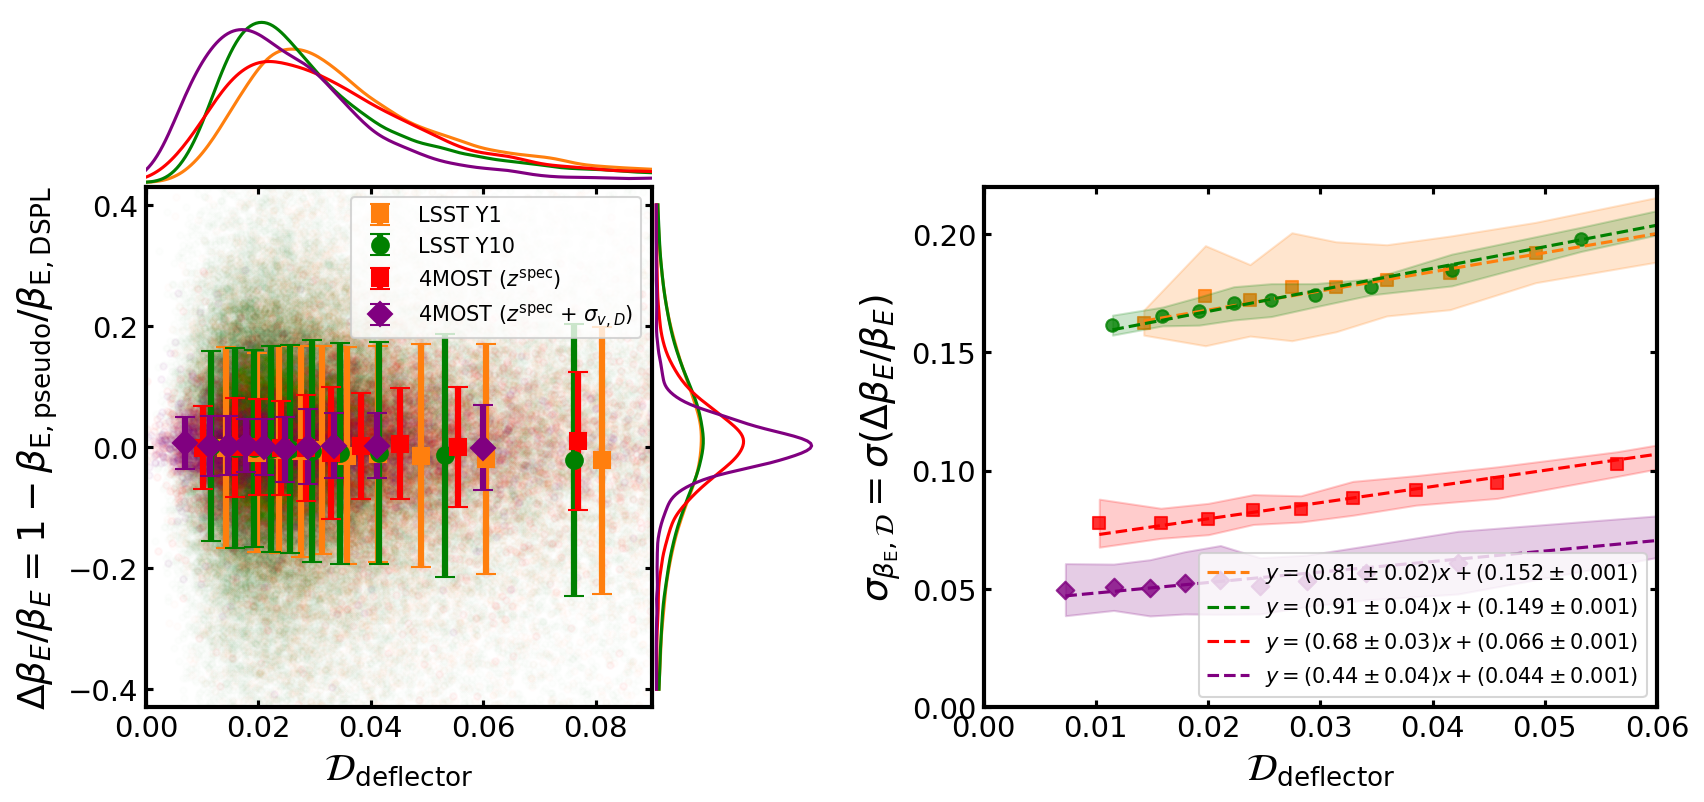

In [66]:
########################################
### scatter_beta_E as a function of dissimilarity
### Linear fit
########################################

alpha_vals = {
    "lsst_y10": 0.007,
    "lsst_y1": 0.01,
    "lsst_4most_spec-z": 0.03,
    "lsst_4most_spec-z_sigma_v": 0.04,
}

markers = {
    "lsst_y10": "o",
    "lsst_y1": "s",
    "lsst_4most_spec-z": "s",
    "lsst_4most_spec-z_sigma_v": "D",
}

# --- Set up figure layout
fig = plt.figure(figsize=(13, 6))
gs = GridSpec(4, 9, figure=fig, wspace=-0.02, hspace=-0.02)

ax_scatter = fig.add_subplot(gs[1:, 0:3])
ax_histx   = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
ax_histy   = fig.add_subplot(gs[1:, 3], sharey=ax_scatter)
ax_fit = fig.add_subplot(gs[1:, 5:9])

ignore_keys = []

# --- Loop through samples
for sample_key, s in pdspl_samples.items() :
    if sample_key in ignore_keys:
        continue
    
    # -------------------------------------------------------
    # LEFT PANEL: Plot the LAST realization (s contains data from last loop)
    # -------------------------------------------------------
    tbl_err = s["pairs_analysis"]["pairs_table_with_errors"]
    tbl = s["pairs_analysis"]["pairs_table"]

    dissimilarities = tbl_err['dissimilarity']
    delta_beta_E = 1 - tbl['beta_E_pseudo'] / tbl['beta_E_DSPL']

    mask = (tbl_err['dissimilarity'] < 0.1) & (np.isfinite(delta_beta_E))
    tbl_err = tbl_err[mask]
    tbl = tbl[mask]
    dissimilarities = dissimilarities[mask]
    delta_beta_E = delta_beta_E[mask]

    # Scatter
    ax_scatter.scatter(
        dissimilarities,
        delta_beta_E,
        color=s['color'],
        alpha=alpha_vals[sample_key],
        s=10,
    )

    # KDE smoothed histograms
    try:
        kde_x = gaussian_kde(dissimilarities)
        kde_y = gaussian_kde(delta_beta_E)
        x_grid = np.linspace(0, 0.1, 200)
        y_grid = np.linspace(-0.4, 0.4, 200)
        ax_histx.plot(x_grid, kde_x(x_grid), color=s['color'], lw=1.5)
        ax_histy.plot(kde_y(y_grid), y_grid, color=s['color'], lw=1.5)
    except:
        pass # Handle cases with too few points for KDE

    # Binning for Error Bars on Left Panel (Last Realization)
    percentiles = np.percentile(dissimilarities, np.arange(0, 101, 10))
    digitized = np.digitize(dissimilarities, percentiles)

    binned_dissimilarities_last = []
    binned_means_beta_E_last = []
    binned_scatter_beta_E_last = []

    for i in range(1, len(percentiles)):
        bin_mask = digitized == i
        if np.sum(bin_mask) > 0:
            binned_dissimilarities_last.append(np.median(dissimilarities[bin_mask]))
            binned_scatter_beta_E_last.append(np.nanstd(delta_beta_E[bin_mask]))
            binned_means_beta_E_last.append(np.nanmean(delta_beta_E[bin_mask]))

    ax_scatter.errorbar(
        binned_dissimilarities_last,
        binned_means_beta_E_last,
        yerr=binned_scatter_beta_E_last,
        fmt=markers[sample_key],
        color=s['color'],
        markersize=8,
        label=s['name'],
        capsize=5,
        elinewidth=3,
    )

    # -------------------------------------------------------
    # RIGHT PANEL: MC Statistics (Mean Scatter vs Mean Dissimilarity)
    # -------------------------------------------------------
    
    # Retrieve all runs data
    # Shape: (N_realizations, N_bins)
    all_dissim_bins = np.array(mc_results[sample_key]['binned_dissim'])
    all_scatter_bins = np.array(mc_results[sample_key]['binned_scatter'])

    # Calculate statistics across realizations (columns are bins)
    mean_dissim = np.nanmean(all_dissim_bins, axis=0)
    mean_scatter = np.nanmean(all_scatter_bins, axis=0)
    std_scatter = np.nanstd(all_scatter_bins, axis=0) # This is the spread across realizations

    # Plot the mean scatter vs mean dissimilarity
    ax_fit.scatter(
        mean_dissim,
        mean_scatter,
        marker=markers[sample_key],
        color=s['color'],
        alpha=0.8,
    )
    
    # Fit line to the MEAN values
    # Filter nans just in case
    valid = np.isfinite(mean_dissim) & np.isfinite(mean_scatter)

    # Filter arrays
    x_data = mean_dissim[valid]
    y_data = mean_scatter[valid]
    y_err  = std_scatter[valid]
    
    if np.sum(valid) > 2:
        # --- LINEAR FIT (y = mx + c) ---
        
        # Calculate weights: w = 1 / sigma
        # Handle cases where sigma might be zero (infinite weight) or NaN
        weights = np.where((y_err > 0) & np.isfinite(y_err), 1.0 / y_err, 0.0)

        # Fit with weights (Degree 1)
        coeffs, cov = np.polyfit(x_data, y_data, 1, w=weights, cov=True)
        
        # Format equation for legend: y = (m ± dm)x + (c ± dc)
        fit_eq_latex = r"$y = (%.2f \pm %.2f) x + (%.3f \pm %.3f)$" % (
            coeffs[0], np.sqrt(cov[0, 0]), # Slope m
            coeffs[1], np.sqrt(cov[1, 1])  # Intercept c
        )

        # Plot fitted line
        # Use polyval on the x_data range
        ax_fit.plot(
            x_data,
            np.polyval(coeffs, x_data),
            linestyle='--',
            color=s['color'],
            label = fit_eq_latex
        )

        # Save fit results to dict
        s['pairs_analysis']['scatter_vs_dissimilarity_fit_coeffs'] = coeffs
        s['pairs_analysis']['scatter_vs_dissimilarity_fit_cov'] = cov
        print(f"{s['name']}: Linear fit: slope = {coeffs[0]:.3f}, intercept = {coeffs[1]:.3f}")

    # Plot the SPREAD (Standard Deviation) across realizations as a shaded region
    # Centered on the mean curve
    ax_fit.fill_between(
        mean_dissim[valid],
        mean_scatter[valid] - std_scatter[valid],
        mean_scatter[valid] + std_scatter[valid],
        color=s['color'],
        alpha=0.2,
    )

# --- Labels, limits, etc.
ax_scatter.set_xlabel(r"$\mathcal{D}_{\rm deflector}$")
ax_scatter.set_ylabel(r"$\Delta \beta_{E} / \beta_{E} = 1 - \beta_{\rm E, pseudo}/\beta_{\rm E, DSPL}$")
ax_scatter.set_xlim(0, 0.09)
ax_scatter.set_ylim(-0.43, 0.43)
ax_scatter.legend(frameon=True)

# --- Hide axis for the marginal histograms
ax_histx.axis('off')
ax_histy.axis('off')

# --- Fit panel axis labels
ax_fit.set_xlabel(r"$\mathcal{D}_{\rm deflector}$")
ax_fit.set_ylabel(r"$\sigma_{\beta_{\rm E},\rm \mathcal{D}} = \sigma(\Delta \beta_{E} / \beta_{E})$")
ax_fit.set_xlim(0, 0.06)
ax_fit.set_ylim(0, 0.22)
ax_fit.legend(frameon=True)

# --- Save figure
fig.savefig(f"../figures/beta_E_vs_D_MC.png", dpi=300, bbox_inches='tight')

In [ ]:
# save the pdspl_samples dict with all the results to a pickle file for later use
# with open('../data/samples/pdspl_samples.pkl', 'wb') as f:
#     pickle.dump(pdspl_samples, f)

In [73]:
########################################################
## Latex Table 3: Number of pairs and scatter_beta_E vs dissimilarity fit parameters
########################################################
print("\nLatex Table 3: Summary of Pairing Analysis Results\n")

keys_to_plot = [
                "lsst_y1",
                "lsst_y10", 
                "lsst_4most_spec-z", 
                "lsst_4most_spec-z_sigma_v"]

print(r"\begin{tabular}{l | c c c | c c}")
print(r"\hline")
print(r"\multirow{2}{*}{\textbf{Sample}} & \multicolumn{3}{c|}{\textbf{Pairing at 20K deg$^2$}} & \multicolumn{2}{c}{\textbf{PL Fit}} \\")
print(r" & \textbf{\# Lenses} & \textbf{\# Pairs} & \textbf{${\Delta\beta_{\rm E}}/{\beta_{\rm E}}$} & \textbf{a} & \textbf{b} \\")
print(r"\hline")

# Loop through paired samples
for key in keys_to_plot:
    s = pdspl_samples[key]
    if "pairs_analysis" not in s:
        continue
    pa = s["pairs_analysis"]
    fit_coeffs = s['pairs_analysis']['scatter_vs_dissimilarity_fit_coeffs']
    fit_covs = s['pairs_analysis']['scatter_vs_dissimilarity_fit_cov']
    a = fit_coeffs[0]
    b = fit_coeffs[1]
    da = np.sqrt(fit_covs[0, 0])
    db = np.sqrt(fit_covs[1, 1])
    
    print(
        f"{s['name']} & "
        f"{pa['num_lenses']} & "
        f"{pa['num_pairs']} & "
        f"{pa['scatter_in_beta_E']:.2f} & "
        f"{a:.2f} $\\pm$ {da:.2f} & "
        f"{b:.2f} $\\pm$ {db:.3f} \\\\"
    )

print(r"\hline")
print(r"\end{tabular}")
########################################################



Latex Table 3: Summary of Pairing Analysis Results

\begin{tabular}{l | c c c | c c}
\hline
\multirow{2}{*}{\textbf{Sample}} & \multicolumn{3}{c|}{\textbf{Pairing at 20K deg$^2$}} & \multicolumn{2}{c}{\textbf{PL Fit}} \\
 & \textbf{\# Lenses} & \textbf{\# Pairs} & \textbf{${\Delta\beta_{\rm E}}/{\beta_{\rm E}}$} & \textbf{a} & \textbf{b} \\
\hline
LSST Y1 & 38823 & 28759 & 0.19 & 0.81 $\pm$ 0.02 & 0.15 $\pm$ 0.001 \\
LSST Y10 & 116471 & 85936 & 0.19 & 0.91 $\pm$ 0.04 & 0.15 $\pm$ 0.001 \\
4MOST ($z^{\rm spec}$) & 10000 & 7369 & 0.10 & 0.68 $\pm$ 0.03 & 0.07 $\pm$ 0.001 \\
4MOST ($z^{\rm spec}$ + $\sigma_{v, D}$) & 5000 & 3561 & 0.06 & 0.44 $\pm$ 0.04 & 0.04 $\pm$ 0.001 \\
\hline
\end{tabular}


LSST Y1: scatter vs dissimilarity fit (Mean of 100 runs): slope = 0.159, intercept = -0.500
LSST Y10: scatter vs dissimilarity fit (Mean of 100 runs): slope = 0.162, intercept = -0.498
4MOST ($z^{\rm spec}$): scatter vs dissimilarity fit (Mean of 100 runs): slope = 0.277, intercept = -0.629
4MOST ($z^{\rm spec}$ + $\sigma_{v, D}$): scatter vs dissimilarity fit (Mean of 100 runs): slope = 0.204, intercept = -0.916


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the follow

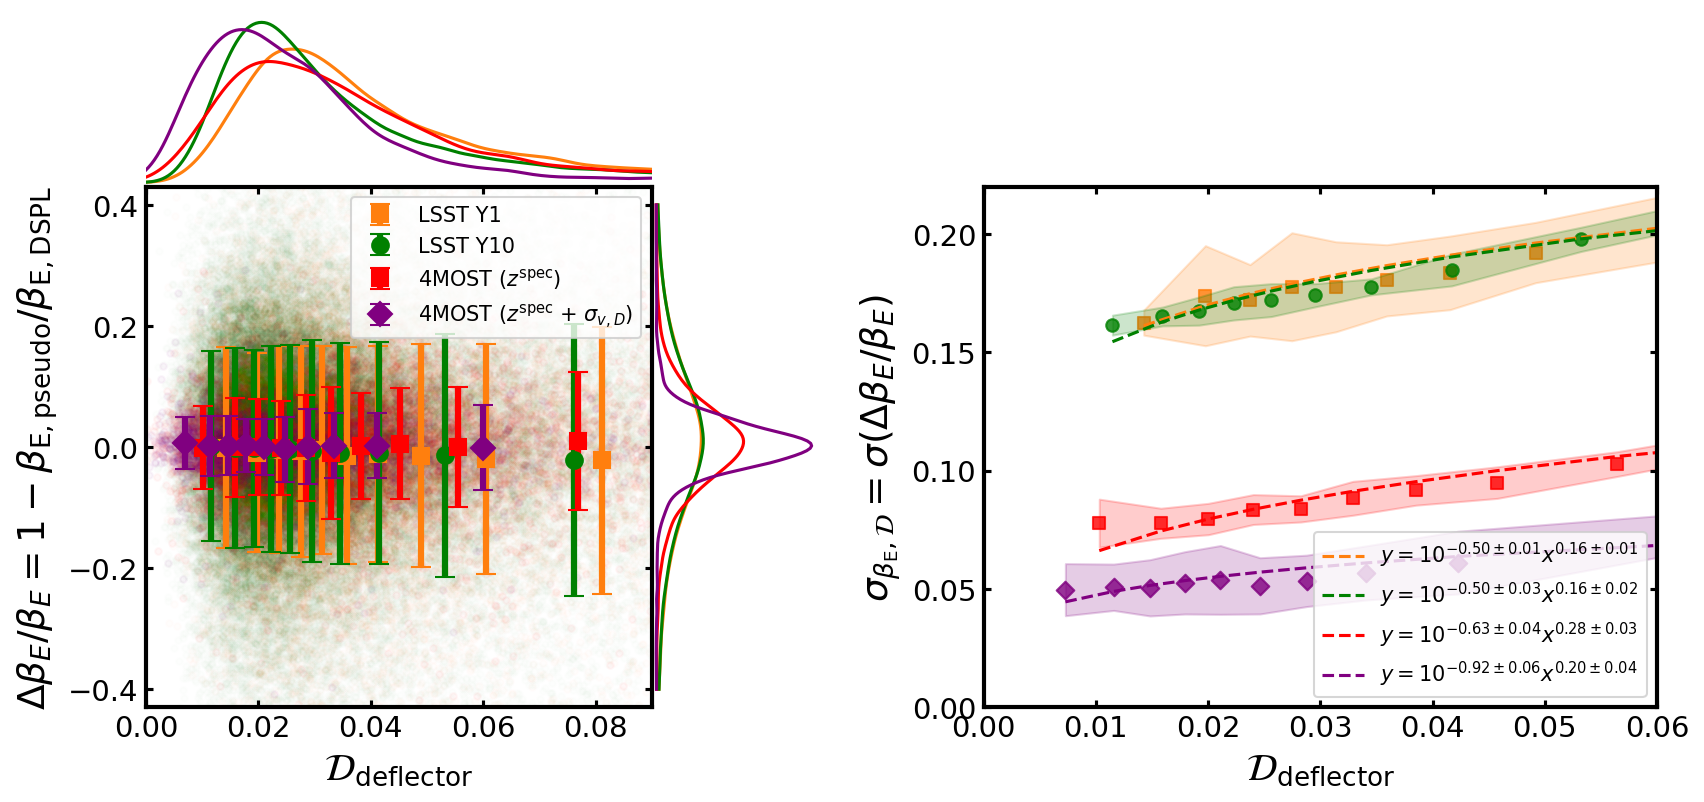

In [65]:
########################################################
########################################
### scatter_beta_E as a function of dissimilarity
### Power law fit
########################################

alpha_vals = {
    "lsst_y10": 0.007,
    "lsst_y1": 0.01,
    "lsst_4most_spec-z": 0.03,
    "lsst_4most_spec-z_sigma_v": 0.04,
}

markers = {
    "lsst_y10": "o",
    "lsst_y1": "s",
    "lsst_4most_spec-z": "s",
    "lsst_4most_spec-z_sigma_v": "D",
}

# --- Set up figure layout
fig = plt.figure(figsize=(13, 6))
gs = GridSpec(4, 9, figure=fig, wspace=-0.02, hspace=-0.02)

ax_scatter = fig.add_subplot(gs[1:, 0:3])
ax_histx   = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
ax_histy   = fig.add_subplot(gs[1:, 3], sharey=ax_scatter)
ax_fit = fig.add_subplot(gs[1:, 5:9])

ignore_keys = []

# --- Loop through samples
for sample_key, s in pdspl_samples.items() :
    if sample_key in ignore_keys:
        continue
    
    # -------------------------------------------------------
    # LEFT PANEL: Plot the LAST realization (s contains data from last loop)
    # -------------------------------------------------------
    tbl_err = s["pairs_analysis"]["pairs_table_with_errors"]
    tbl = s["pairs_analysis"]["pairs_table"]

    dissimilarities = tbl_err['dissimilarity']
    delta_beta_E = 1 - tbl['beta_E_pseudo'] / tbl['beta_E_DSPL']

    mask = (tbl_err['dissimilarity'] < 0.1) & (np.isfinite(delta_beta_E))
    tbl_err = tbl_err[mask]
    tbl = tbl[mask]
    dissimilarities = dissimilarities[mask]
    delta_beta_E = delta_beta_E[mask]

    # Scatter
    ax_scatter.scatter(
        dissimilarities,
        delta_beta_E,
        color=s['color'],
        alpha=alpha_vals[sample_key],
        s=10,
    )

    # KDE smoothed histograms
    try:
        kde_x = gaussian_kde(dissimilarities)
        kde_y = gaussian_kde(delta_beta_E)
        x_grid = np.linspace(0, 0.1, 200)
        y_grid = np.linspace(-0.4, 0.4, 200)
        ax_histx.plot(x_grid, kde_x(x_grid), color=s['color'], lw=1.5)
        ax_histy.plot(kde_y(y_grid), y_grid, color=s['color'], lw=1.5)
    except:
        pass # Handle cases with too few points for KDE

    # Binning for Error Bars on Left Panel (Last Realization)
    percentiles = np.percentile(dissimilarities, np.arange(0, 101, 10))
    digitized = np.digitize(dissimilarities, percentiles)

    binned_dissimilarities_last = []
    binned_means_beta_E_last = []
    binned_scatter_beta_E_last = []

    for i in range(1, len(percentiles)):
        bin_mask = digitized == i
        if np.sum(bin_mask) > 0:
            binned_dissimilarities_last.append(np.median(dissimilarities[bin_mask]))
            binned_scatter_beta_E_last.append(np.nanstd(delta_beta_E[bin_mask]))
            binned_means_beta_E_last.append(np.nanmean(delta_beta_E[bin_mask]))

    ax_scatter.errorbar(
        binned_dissimilarities_last,
        binned_means_beta_E_last,
        yerr=binned_scatter_beta_E_last,
        fmt=markers[sample_key],
        color=s['color'],
        markersize=8,
        label=s['name'],
        capsize=5,
        elinewidth=3,
    )

    # -------------------------------------------------------
    # RIGHT PANEL: MC Statistics (Mean Scatter vs Mean Dissimilarity)
    # -------------------------------------------------------
    
    # Retrieve all runs data
    # Shape: (N_realizations, N_bins)
    all_dissim_bins = np.array(mc_results[sample_key]['binned_dissim'])
    all_scatter_bins = np.array(mc_results[sample_key]['binned_scatter'])

    # Calculate statistics across realizations (columns are bins)
    mean_dissim = np.nanmean(all_dissim_bins, axis=0)
    mean_scatter = np.nanmean(all_scatter_bins, axis=0)
    std_scatter = np.nanstd(all_scatter_bins, axis=0) # This is the spread across realizations

    # Plot the mean scatter vs mean dissimilarity
    ax_fit.scatter(
        mean_dissim,
        mean_scatter,
        marker=markers[sample_key],
        color=s['color'],
        alpha=0.8,
    )
    
    # Fit line to the MEAN values
    # Filter nans just in case
    valid = np.isfinite(mean_dissim) & np.isfinite(mean_scatter)

    # Filter arrays
    x_data = mean_dissim[valid]
    y_data = mean_scatter[valid]
    y_err  = std_scatter[valid]
    
    if np.sum(valid) > 2:
        # 1. Transform data to log10 space
        log_x = np.log10(x_data)
        log_y = np.log10(y_data)

        # 2. Propagate errors to log10 space: sigma_logy = sigma_y / (y * ln(10))
        # Avoid division by zero if error is 0 by adding a tiny epsilon or clipping
        sigma_log_y = y_err / (y_data * np.log(10))
        
        # 3. Calculate weights: w = 1 / sigma
        # Handle cases where sigma might be zero (infinite weight)
        weights = np.where(sigma_log_y > 0, 1.0 / sigma_log_y, 0.0)

        # 4. Fit with weights
        # We pass w=weights so the fit minimizes chi-squared
        coeffs, cov = np.polyfit(log_x, log_y, 1, w=weights, cov=True)
        
        fit_eq_latex = r"$y = 10^{%.2f \pm %.2f} x^{%.2f \pm %.2f}$" % (
            coeffs[1], np.sqrt(cov[1, 1]),
            coeffs[0], np.sqrt(cov[0, 0])
        )

        # fitted line
        ax_fit.plot(
            mean_dissim[valid],
            10**(np.polyval(coeffs, np.log10(mean_dissim[valid]))),
            linestyle='--',
            color=s['color'],
            label = fit_eq_latex
        )

        # Save fit results to dict
        s['pairs_analysis']['scatter_vs_dissimilarity_fit_coeffs'] = coeffs
        print(f"{s['name']}: scatter vs dissimilarity fit (Mean of {N_realizations} runs): slope = {coeffs[0]:.3f}, intercept = {coeffs[1]:.3f}")

    # Plot the SPREAD (Standard Deviation) across realizations as a shaded region
    # Centered on the mean curve
    ax_fit.fill_between(
        mean_dissim[valid],
        mean_scatter[valid] - std_scatter[valid],
        mean_scatter[valid] + std_scatter[valid],
        color=s['color'],
        alpha=0.2,
    )

# --- Labels, limits, etc.
ax_scatter.set_xlabel(r"$\mathcal{D}_{\rm deflector}$")
ax_scatter.set_ylabel(r"$\Delta \beta_{E} / \beta_{E} = 1 - \beta_{\rm E, pseudo}/\beta_{\rm E, DSPL}$")
ax_scatter.set_xlim(0, 0.09)
ax_scatter.set_ylim(-0.43, 0.43)
ax_scatter.legend(frameon=True)

# --- Hide axis for the marginal histograms
ax_histx.axis('off')
ax_histy.axis('off')

# --- Fit panel axis labels
ax_fit.set_xlabel(r"$\mathcal{D}_{\rm deflector}$")
ax_fit.set_ylabel(r"$\sigma_{\beta_{\rm E},\rm \mathcal{D}} = \sigma(\Delta \beta_{E} / \beta_{E})$")
ax_fit.set_xlim(0, 0.06)
ax_fit.set_ylim(0, 0.22)
ax_fit.legend(frameon=True)

# --- Save figure
# fig.savefig(f"../figures/beta_E_vs_D_MC.png", dpi=300, bbox_inches='tight')